# Cartopy Examples

In [1]:
%matplotlib inline

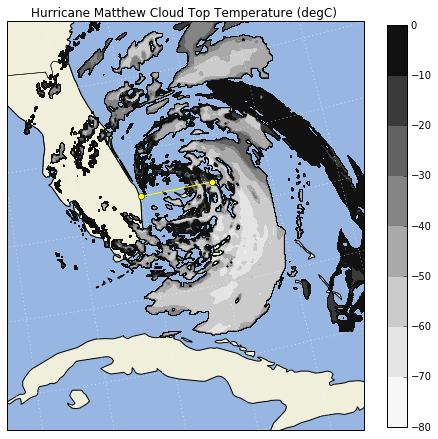

In [2]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import cartopy.feature as cfeature
from netCDF4 import Dataset

from wrf import to_np, getvar, smooth2d, get_cartopy, latlon_coords, CoordPair, GeoBounds, cartopy_xlim, cartopy_ylim

# Open the NetCDF file
ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

# Get sea level pressure and cloud top temperature
slp = getvar(ncfile, "slp")
ctt = getvar(ncfile, "ctt")

# Smooth the SLP
smooth_slp = smooth2d(slp, 3)

# Extract the latitude and longitude coordinate arrays as regular numpy array instead of xarray.DataArray
lats, lons = latlon_coords(slp)

# Get the cartopy projection class
cart_proj = get_cartopy(slp)

# Create the figure
fig = plt.figure(figsize=(8,8))
ax = plt.axes(projection=cart_proj)

# Download and create the states, land, and oceans using cartopy features
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', 
                                    facecolor=cfeature.COLORS['land'])
ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean', scale='50m', 
                                     facecolor=cfeature.COLORS['water'])

# Make the pressure contours.
#contour_levels = [960, 965, 970, 975, 980, 990]
#c1 = plt.contour(lons, lats, to_np(smooth_slp), levels=contour_levels, colors="white", 
#            transform=crs.PlateCarree(), zorder=3, linewidths=1.0)

# Add pressure contour labels
#plt.clabel(c1, contour_levels, inline=True, fmt='%.0f', fontsize=7)

# Create the filled cloud top temperature contours
#contour_levels = [-80, -70, -60, -50, -40, -30, -20, -10, 0]
contour_levels = np.arange(-80.0, 10.0, 10.0)
plt.contourf(to_np(lons), to_np(lats), to_np(ctt), contour_levels, cmap=get_cmap("Greys"),
             transform=crs.PlateCarree(), zorder=2)

plt.plot([-80,-77.8], [26.76,26.76], color="yellow", marker="o", transform=crs.PlateCarree(), zorder=3)

# Create the label bar for cloud top temperature
#cb2 = plt.colorbar(ax=ax, fraction=0.046, pad=0.04)
cb2 = plt.colorbar(ax=ax, shrink=.90)

# Draw the oceans, land, and states
ax.add_feature(ocean)
ax.add_feature(land)
ax.add_feature(states, linewidth=.5, edgecolor="black")

# Crop the domain to the region around the hurricane
hur_bounds = GeoBounds(CoordPair(lat=np.amin(to_np(lats)), lon=-85.0),
                       CoordPair(lat=30.0, lon=-72.0))
ax.set_xlim(cartopy_xlim(ctt, geobounds=hur_bounds))
ax.set_ylim(cartopy_ylim(ctt, geobounds=hur_bounds))
ax.gridlines(color="white", linestyle="dotted")

# Add the title and show the image
plt.title("Hurricane Matthew Cloud Top Temperature (degC) ")
#plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/matthew.png",
#           transparent=True, bbox_inches="tight")
plt.show()


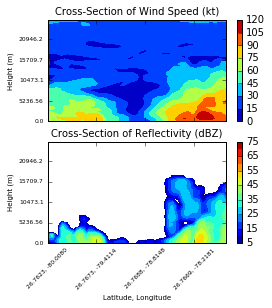

In [3]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function, unicode_literals)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset

from wrf import to_np, getvar, smooth2d, ll_to_xy, CoordPair, vertcross, getproj, get_proj_params, to_xy_coords, latlon_coords

# Open the NetCDF file
ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

# Extract model height, dbz, and wind speed
z = getvar(ncfile, "z", timeidx=0)
dbz = getvar(ncfile, "dbz", timeidx=0)
wspd =  getvar(ncfile, "uvmet_wspd_wdir", units="kt")[0,:]
Z = 10**(dbz/10.)

start_point = CoordPair(lat=26.75, lon=-80.0)
end_point = CoordPair(lat=26.75, lon=-77.8)

# Compute the vertical cross-section interpolation.  Also, include the lat/lon points along the cross-section.
z_cross = vertcross(Z, z, wrfin=ncfile, start_point=start_point, end_point=end_point, latlon=True, meta=True)
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point, end_point=end_point, latlon=True, meta=True)
dbz_cross = 10.0 * np.log10(z_cross)

# Create the figure
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(4,4))
#ax = plt.axes([0.1,0.1,0.8,0.8])

# Define the contour levels [0, 50, 100, 150, ....]
levels = [5 + 5*n for n in range(15)]

# Make the contour plot
a = axes[0].contourf(to_np(wspd_cross))
# Add the color bar
fig.colorbar(a, ax=axes[0])

b = axes[1].contourf(to_np(dbz_cross), levels=levels)
fig.colorbar(b, ax=axes[1])

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
axes[0].set_xticks(x_ticks[::20])
axes[0].set_xticklabels([], rotation=45)
axes[1].set_xticks(x_ticks[::20])
axes[1].set_xticklabels(x_labels[::20], rotation=45, fontsize=6) 


# Set the y-ticks to be height.
vert_vals = to_np(dbz_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
axes[0].set_yticks(v_ticks[::20])
axes[0].set_yticklabels(vert_vals[::20], fontsize=6) 
axes[1].set_yticks(v_ticks[::20])
axes[1].set_yticklabels(vert_vals[::20], fontsize=6) 

# Set the x-axis and  y-axis labels
axes[1].set_xlabel("Latitude, Longitude", fontsize=7)
axes[0].set_ylabel("Height (m)", fontsize=7)
axes[1].set_ylabel("Height (m)", fontsize=7)

# Add a title
axes[0].set_title("Cross-Section of Wind Speed (kt)", {"fontsize" : 10})
axes[1].set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 10})

plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/matthew_cross.png",
           transparent=True, bbox_inches="tight")
plt.show()

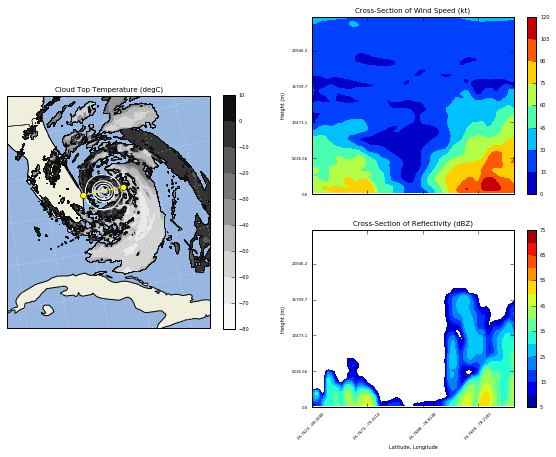

In [4]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function, unicode_literals)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import cartopy.feature as cfeature
from netCDF4 import Dataset

from wrf import (getvar, to_np, vertcross, smooth2d, CoordPair, GeoBounds, get_cartopy, 
                 latlon_coords, cartopy_xlim, cartopy_ylim)

# Open the NetCDF file
ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

# Get the WRF variables
slp = getvar(ncfile, "slp")
smooth_slp = smooth2d(slp, 3)
ctt = getvar(ncfile, "ctt")
z = getvar(ncfile, "z", timeidx=0)
dbz = getvar(ncfile, "dbz", timeidx=0)
Z = 10**(dbz/10.)
wspd =  getvar(ncfile, "wspd_wdir", units="kt")[0,:]

# Set the start point and end point for the cross section
start_point = CoordPair(lat=26.76, lon=-80.0)
end_point = CoordPair(lat=26.76, lon=-77.8)

# Compute the vertical cross-section interpolation.  Also, include the lat/lon points along the cross-section 
# in the metadata by setting latlon to True.
z_cross = vertcross(Z, z, wrfin=ncfile, start_point=start_point, end_point=end_point, latlon=True, meta=True)
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point, end_point=end_point, latlon=True, meta=True)
dbz_cross = 10.0 * np.log10(z_cross)

# Get the lat/lon points
lats, lons = latlon_coords(slp)

# Get the cartopy projection object
cart_proj = get_cartopy(slp)

# Create a figure that will have 3 subplots
fig = plt.figure(figsize=(10,7))
ax_ctt = fig.add_subplot(1,2,1,projection=cart_proj)
ax_wspd = fig.add_subplot(2,2,2)
ax_dbz = fig.add_subplot(2,2,4)

# Download and create the states, land, and oceans using cartopy features
states = cfeature.NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', 
                                    facecolor=cfeature.COLORS['land'])
ocean = cfeature.NaturalEarthFeature(category='physical', name='ocean', scale='50m', 
                                     facecolor=cfeature.COLORS['water'])

# Make the pressure contours
contour_levels = [960, 965, 970, 975, 980, 990]
c1 = ax_ctt.contour(lons, lats, to_np(smooth_slp), levels=contour_levels, colors="white", 
            transform=crs.PlateCarree(), zorder=3, linewidths=1.0)

# Create the filled cloud top temperature contours
contour_levels = [-80.0, -70.0, -60, -50, -40, -30, -20, -10, 0, 10]
ctt_contours = ax_ctt.contourf(to_np(lons), to_np(lats), to_np(ctt), contour_levels, cmap=get_cmap("Greys"),
             transform=crs.PlateCarree(), zorder=2)

ax_ctt.plot([start_point.lon, end_point.lon], [start_point.lat, end_point.lat], color="yellow", 
            marker="o", transform=crs.PlateCarree(), zorder=3)

# Create the color bar for cloud top temperature
cb_ctt = fig.colorbar(ctt_contours, ax=ax_ctt, shrink=.60)
cb_ctt.ax.tick_params(labelsize=5)

# Draw the oceans, land, and states
ax_ctt.add_feature(ocean)
ax_ctt.add_feature(land)
ax_ctt.add_feature(states, linewidth=.5, edgecolor="black")

# Crop the domain to the region around the hurricane
hur_bounds = GeoBounds(CoordPair(lat=np.amin(to_np(lats)), lon=-85.0),
                       CoordPair(lat=30.0, lon=-72.0))
ax_ctt.set_xlim(cartopy_xlim(ctt, geobounds=hur_bounds))
ax_ctt.set_ylim(cartopy_ylim(ctt, geobounds=hur_bounds))
ax_ctt.gridlines(color="white", linestyle="dotted")

# Make the contour plot for wind speed
wspd_contours = ax_wspd.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))
# Add the color bar
cb_wspd = fig.colorbar(wspd_contours, ax=ax_wspd)
cb_wspd.ax.tick_params(labelsize=5)

# Make the contour plot for dbz
levels = [5 + 5*n for n in range(15)]
dbz_contours = ax_dbz.contourf(to_np(dbz_cross), levels=levels, cmap=get_cmap("jet"))
cb_dbz = fig.colorbar(dbz_contours, ax=ax_dbz)
cb_dbz.ax.tick_params(labelsize=5)

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
ax_wspd.set_xticks(x_ticks[::20])
ax_wspd.set_xticklabels([], rotation=45)
ax_dbz.set_xticks(x_ticks[::20])
ax_dbz.set_xticklabels(x_labels[::20], rotation=45, fontsize=4) 

# Set the y-ticks to be height
vert_vals = to_np(dbz_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax_wspd.set_yticks(v_ticks[::20])
ax_wspd.set_yticklabels(vert_vals[::20], fontsize=4) 
ax_dbz.set_yticks(v_ticks[::20])
ax_dbz.set_yticklabels(vert_vals[::20], fontsize=4) 

# Set the x-axis and  y-axis labels
ax_dbz.set_xlabel("Latitude, Longitude", fontsize=5)
ax_wspd.set_ylabel("Height (m)", fontsize=5)
ax_dbz.set_ylabel("Height (m)", fontsize=5)

# Add a title
ax_ctt.set_title("Cloud Top Temperature (degC)", {"fontsize" : 7})
ax_wspd.set_title("Cross-Section of Wind Speed (kt)", {"fontsize" : 7})
ax_dbz.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 7})

plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/matthew.png",
           transparent=True, bbox_inches="tight")
plt.show()

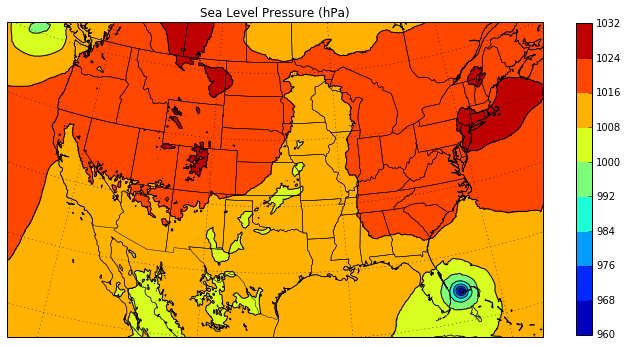

In [5]:
%matplotlib inline
# SLP
from __future__ import (absolute_import, division, print_function, unicode_literals)
    
from netCDF4 import Dataset   
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

from wrf import to_np, getvar, smooth2d, get_cartopy, cartopy_xlim, cartopy_ylim

# Open the NetCDF file
ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

# Get the sea level pressure
slp = getvar(ncfile, "slp")

# Smooth the sea level pressure since it tends to be noisy near the mountains
smooth_slp = smooth2d(slp, 3)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

# Create a figure
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, linewidth=.5)
ax.coastlines('50m', linewidth=0.8)

# Make the contour outlines and filled contours for the smoothed sea level pressure.
plt.contour(to_np(lons), to_np(lats), to_np(smooth_slp), 10, colors="black", transform=crs.PlateCarree())
plt.contourf(to_np(lons), to_np(lats), to_np(smooth_slp), 10, transform=crs.PlateCarree(), cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(ax=ax, shrink=.62)

# Set the map limits.  Not really necessary, but used for demonstration.
ax.set_xlim(cartopy_xlim(smooth_slp))
ax.set_ylim(cartopy_ylim(smooth_slp))

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title("Sea Level Pressure (hPa)")

plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/cartopy_slp.png",
           transparent=True, bbox_inches="tight")

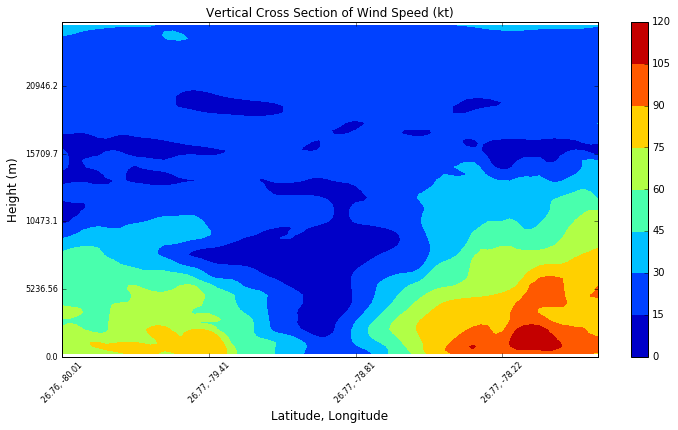

In [6]:
%matplotlib inline

from __future__ import (absolute_import, division, print_function, unicode_literals)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset

from wrf import to_np, getvar, CoordPair, vertcross

# Open the NetCDF file
filename = "/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00"
ncfile = Dataset(filename)

# Extract the model height and wind speed
z = getvar(ncfile, "z")
wspd =  getvar(ncfile, "uvmet_wspd_wdir", units="kt")[0,:]

# Create the start point and end point for the cross section
start_point = CoordPair(lat=26.76, lon=-80.0)
end_point = CoordPair(lat=26.76, lon=-77.8)

# Compute the vertical cross-section interpolation.  Also, include the lat/lon points along the cross-section.
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point, end_point=end_point, latlon=True, meta=True)

# Create the figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

# Make the contour plot
wspd_contours = ax.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))

# Add the color bar
plt.colorbar(wspd_contours, ax=ax)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(wspd_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}") for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8) 

# Set the y-ticks to be height.
vert_vals = to_np(wspd_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::20])
ax.set_yticklabels(vert_vals[::20], fontsize=8) 

# Set the x-axis and  y-axis labels
ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)

plt.title("Vertical Cross Section of Wind Speed (kt)")

plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/cartopy_cross.png",
           transparent=True, bbox_inches="tight")

plt.show()

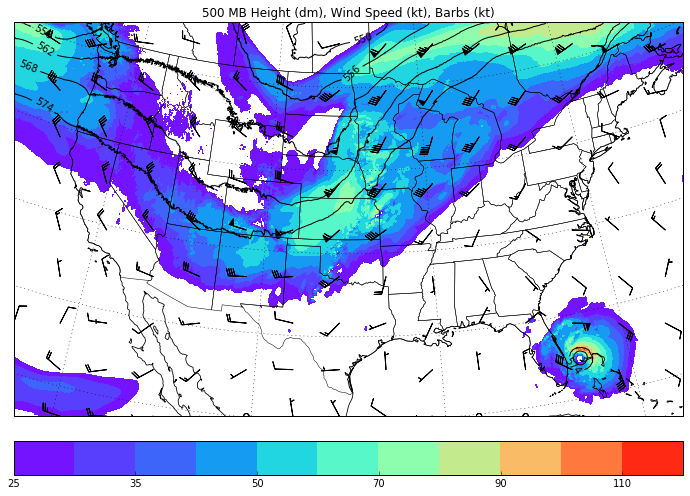

In [7]:
from __future__ import (absolute_import, division, print_function, unicode_literals)

from netCDF4 import Dataset 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature

from wrf import getvar, interplevel, to_np, latlon_coords, get_cartopy, cartopy_xlim, cartopy_ylim

# Open the NetCDF file
ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

# Extract the pressure, geopotential height, and wind variables
p = getvar(ncfile, "pressure")
z = getvar(ncfile, "z", units="dm")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]

# Interpolate geopotential height, u, and v winds to 500 hPa 
ht_500 = interplevel(z, p, 500)
u_500 = interplevel(ua, p, 500)
v_500 = interplevel(va, p, 500)
wspd_500 = interplevel(wspd, p, 500)

# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the map projection information
cart_proj = get_cartopy(ht_500)

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

# Add the 500 hPa geopotential height contours
levels = np.arange(520., 580., 6.)
contours = plt.contour(to_np(lons), to_np(lats), to_np(ht_500), levels=levels, colors="black", 
            transform=crs.PlateCarree())
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed contours
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
wspd_contours = plt.contourf(to_np(lons), to_np(lats), to_np(wspd_500), levels=levels,
                             cmap=get_cmap("rainbow"), 
                             transform=crs.PlateCarree())
plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=.05)

# Add the 500 hPa wind barbs, only plotting every 125th data point.
plt.barbs(to_np(lons[::125,::125]), to_np(lats[::125,::125]), to_np(u_500[::125, ::125]), 
          to_np(v_500[::125, ::125]), transform=crs.PlateCarree(), length=6)

# Set the map bounds
ax.set_xlim(cartopy_xlim(ht_500))
ax.set_ylim(cartopy_ylim(ht_500))

ax.gridlines()

plt.title("500 MB Height (dm), Wind Speed (kt), Barbs (kt)")

plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/cartopy_500.png",
           transparent=True, bbox_inches="tight")

plt.show()

In [8]:
from __future__ import print_function
    
from netCDF4 import Dataset
from wrf import getvar, get_cartopy, latlon_coords, geo_bounds

ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

slp = getvar(ncfile, "slp")

# Get the cartopy mapping object
cart_proj = get_cartopy(slp)

print (cart_proj)

# Get the latitude and longitude coordinate.  This is needed for plotting.
lats, lons = latlon_coords(slp)

# Get the geobounds for the full domain
bounds = geo_bounds(slp)
print (bounds)

# Get the geographic boundaries for a subset of the domain
slp_subset = slp[150:250, 150:250]
slp_subset_bounds = geo_bounds(slp_subset)

print (slp_subset_bounds)

GeoBounds(CoordPair(lat=21.1381225586, lon=-122.719528198), CoordPair(lat=47.8436355591, lon=-60.9013671875))
GeoBounds(CoordPair(lat=25.9246292114, lon=-119.675048828), CoordPair(lat=29.0761833191, lon=-117.46484375))


In [9]:
from __future__ import print_function
    
from netCDF4 import Dataset
from wrf import get_cartopy, geo_bounds

ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

cart_proj = get_cartopy(wrfin=ncfile)

print (cart_proj)

bounds = geo_bounds(wrfin=ncfile)

print (bounds)

GeoBounds(CoordPair(lat=21.1381225586, lon=-122.719528198), CoordPair(lat=47.8436355591, lon=-60.9013671875))


# Basemap Examples

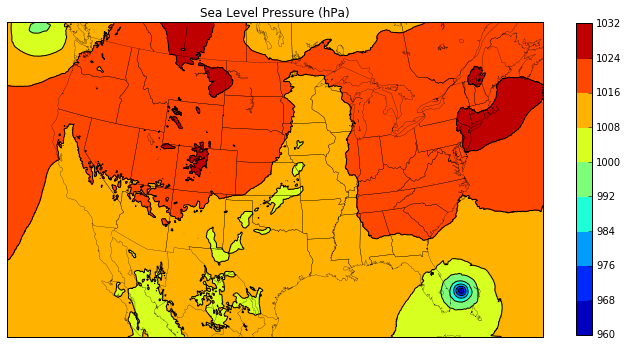

In [10]:

from __future__ import (absolute_import, division, print_function, unicode_literals)
    
from netCDF4 import Dataset   
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from mpl_toolkits.basemap import Basemap

from wrf import to_np, getvar, smooth2d, get_basemap, latlon_coords

# Open the NetCDF file
ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

# Get the sea level pressure
slp = getvar(ncfile, "slp")

# Smooth the sea level pressure since it tends to be noisy near the mountains
smooth_slp = smooth2d(slp, 3)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Get the basemap object
bm = get_basemap(slp)

# Create a figure
fig = plt.figure(figsize=(12,9))

# Add geographic outlines
bm.drawcoastlines(linewidth=0.25)
bm.drawstates(linewidth=0.25)
bm.drawcountries(linewidth=0.25)

# Convert the lats and lons to x and y.  Make sure you convert the lats and lons to 
# numpy arrays via to_np, or basemap crashes with an undefined RuntimeError.
x, y = bm(to_np(lons), to_np(lats))

# Draw the contours and filled contours
bm.contour(x, y, to_np(smooth_slp), 10, colors="black")
bm.contourf(x, y, to_np(smooth_slp), 10, cmap=get_cmap("jet"))

# Add a color bar
plt.colorbar(shrink=.62)

plt.title("Sea Level Pressure (hPa)")

plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/basemap_slp.png",
           transparent=True, bbox_inches="tight")

plt.show()

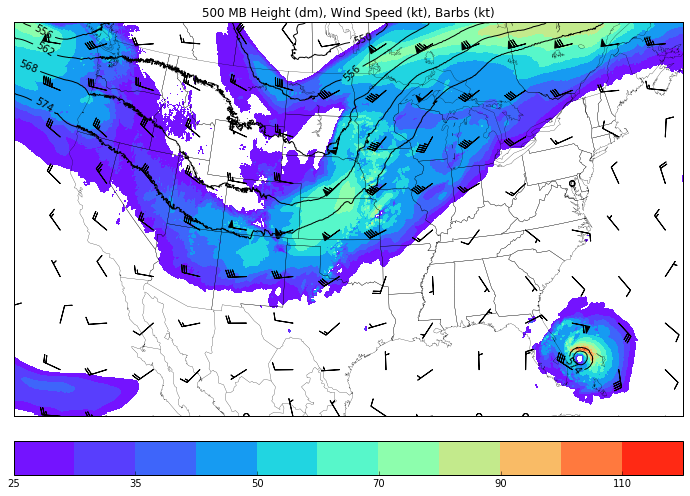

In [11]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function, unicode_literals)

from netCDF4 import Dataset 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords

# Open the NetCDF file
ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

# Extract the pressure, geopotential height, and wind variables
p = getvar(ncfile, "pressure")
z = getvar(ncfile, "z", units="dm")
ua = getvar(ncfile, "ua", units="kt")
va = getvar(ncfile, "va", units="kt")
wspd = getvar(ncfile, "wspd_wdir", units="kts")[0,:]

# Interpolate geopotential height, u, and v winds to 500 hPa 
ht_500 = interplevel(z, p, 500)
u_500 = interplevel(ua, p, 500)
v_500 = interplevel(va, p, 500)
wspd_500 = interplevel(wspd, p, 500)

# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_500)

# Get the basemap object
bm = get_basemap(ht_500)

# Create the figure
fig = plt.figure(figsize=(12,9))
ax = plt.axes()

# Convert the lat/lon coordinates to x/y coordinates in the projection space
x, y = bm(to_np(lons), to_np(lats))

# Add the 500 hPa geopotential height contours
levels = np.arange(520., 580., 6.)
contours = bm.contour(x, y, to_np(ht_500), levels=levels, colors="black")
plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed contours
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
wspd_contours = bm.contourf(x, y, to_np(wspd_500), levels=levels,
                             cmap=get_cmap("rainbow"))
plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", pad=.05)

# Add the geographic boundaries
bm.drawcoastlines(linewidth=0.25)
bm.drawstates(linewidth=0.25)
bm.drawcountries(linewidth=0.25)

# Add the 500 hPa wind barbs, only plotting every 125th data point.
bm.barbs(x[::125,::125], y[::125,::125], to_np(u_500[::125, ::125]), 
          to_np(v_500[::125, ::125]), length=6)

plt.title("500 MB Height (dm), Wind Speed (kt), Barbs (kt)")

plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/basemap_500.png",
           transparent=True, bbox_inches="tight")

plt.show()

/Users/ladwig/miniconda2/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:1662: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif fill_color == 'none' or fill_color == 'None':


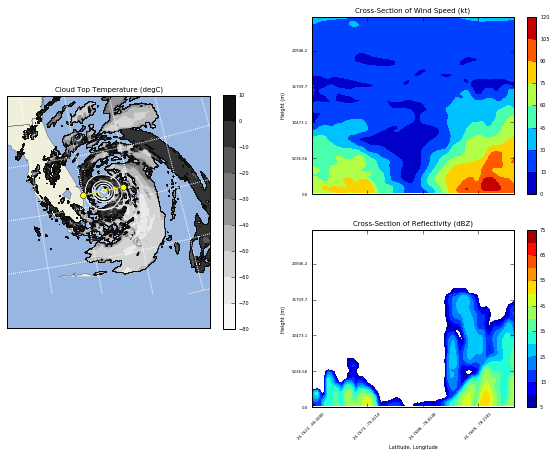

In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from netCDF4 import Dataset

from wrf import getvar, to_np, vertcross, smooth2d, CoordPair, get_basemap, latlon_coords

# Open the NetCDF file
ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

# Get the WRF variables
slp = getvar(ncfile, "slp")
smooth_slp = smooth2d(slp, 3)
ctt = getvar(ncfile, "ctt")
z = getvar(ncfile, "z", timeidx=0)
dbz = getvar(ncfile, "dbz", timeidx=0)
Z = 10**(dbz/10.)
wspd =  getvar(ncfile, "wspd_wdir", units="kt")[0,:]

# Set the start point and end point for the cross section
start_point = CoordPair(lat=26.76, lon=-80.0)
end_point = CoordPair(lat=26.76, lon=-77.8)

# Compute the vertical cross-section interpolation.  Also, include the lat/lon points along the cross-section in 
# the metadata by setting latlon to True.
z_cross = vertcross(Z, z, wrfin=ncfile, start_point=start_point, end_point=end_point, latlon=True, meta=True)
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point, end_point=end_point, latlon=True, meta=True)
dbz_cross = 10.0 * np.log10(z_cross)

# Get the latitude and longitude points
lats, lons = latlon_coords(slp)

# Create the figure that will have 3 subplots
fig = plt.figure(figsize=(10,7))
ax_ctt = fig.add_subplot(1,2,1)
ax_wspd = fig.add_subplot(2,2,2)
ax_dbz = fig.add_subplot(2,2,4)

# Get the basemap object
bm = get_basemap(slp)

# Convert the lat/lon points in to x/y points in the projection space
x, y = bm(to_np(lons), to_np(lats))

# Make the pressure contours
contour_levels = [960, 965, 970, 975, 980, 990]
c1 = bm.contour(x, y, to_np(smooth_slp), levels=contour_levels, colors="white", 
                zorder=3, linewidths=1.0, ax=ax_ctt)

# Create the filled cloud top temperature contours
contour_levels = [-80.0, -70.0, -60, -50, -40, -30, -20, -10, 0, 10]
ctt_contours = bm.contourf(x, y, to_np(ctt), contour_levels, cmap=get_cmap("Greys"),
                               zorder=2, ax=ax_ctt)

point_x, point_y = bm([start_point.lon, end_point.lon], [start_point.lat, end_point.lat])
bm.plot([point_x[0], point_x[1]], [point_y[0], point_y[1]], color="yellow", 
            marker="o", zorder=3, ax=ax_ctt)

# Create the color bar for cloud top temperature
cb_ctt = fig.colorbar(ctt_contours, ax=ax_ctt, shrink=.60)
cb_ctt.ax.tick_params(labelsize=5)

# Draw the oceans, land, and states
bm.drawcoastlines(linewidth=0.25, ax=ax_ctt)
bm.drawstates(linewidth=0.25, ax=ax_ctt)
bm.drawcountries(linewidth=0.25, ax=ax_ctt)
bm.fillcontinents(color=np.array([ 0.9375 , 0.9375 , 0.859375]), 
                  ax=ax_ctt, lake_color=np.array([ 0.59375 , 0.71484375, 0.8828125 ]))
bm.drawmapboundary(fill_color=np.array([ 0.59375 , 0.71484375, 0.8828125 ]), ax=ax_ctt)

# Draw Parallels
parallels = np.arange(np.amin(lats), 30., 2.5)
bm.drawparallels(parallels, ax=ax_ctt, color="white")

merids = np.arange(-85.0, -72.0, 2.5)
bm.drawmeridians(merids, ax=ax_ctt, color="white")

# Crop the image to the hurricane region
x_start, y_start = bm(-85.0, np.amin(lats))
x_end, y_end = bm(-72.0, 30.0)

ax_ctt.set_xlim([x_start, x_end])
ax_ctt.set_ylim([y_start, y_end])

# Make the contour plot for wspd
wspd_contours = ax_wspd.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))
# Add the color bar
cb_wspd = fig.colorbar(wspd_contours, ax=ax_wspd)
cb_wspd.ax.tick_params(labelsize=5)

# Make the contour plot for dbz
levels = [5 + 5*n for n in range(15)]
dbz_contours = ax_dbz.contourf(to_np(dbz_cross), levels=levels, cmap=get_cmap("jet"))
cb_dbz = fig.colorbar(dbz_contours, ax=ax_dbz)
cb_dbz.ax.tick_params(labelsize=5)

# Set the x-ticks to use latitude and longitude labels.
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
ax_wspd.set_xticks(x_ticks[::20])
ax_wspd.set_xticklabels([], rotation=45)
ax_dbz.set_xticks(x_ticks[::20])
ax_dbz.set_xticklabels(x_labels[::20], rotation=45, fontsize=4) 

# Set the y-ticks to be height.
vert_vals = to_np(dbz_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax_wspd.set_yticks(v_ticks[::20])
ax_wspd.set_yticklabels(vert_vals[::20], fontsize=4) 
ax_dbz.set_yticks(v_ticks[::20])
ax_dbz.set_yticklabels(vert_vals[::20], fontsize=4) 

# Set the x-axis and  y-axis labels
ax_dbz.set_xlabel("Latitude, Longitude", fontsize=5)
ax_wspd.set_ylabel("Height (m)", fontsize=5)
ax_dbz.set_ylabel("Height (m)", fontsize=5)

# Add titles
ax_ctt.set_title("Cloud Top Temperature (degC)", {"fontsize" : 7})
ax_wspd.set_title("Cross-Section of Wind Speed (kt)", {"fontsize" : 7})
ax_dbz.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 7})

plt.savefig("/Users/ladwig/Documents/workspace/wrf_python/doc/source/_static/images/basemap_front.png",
           transparent=False, bbox_inches="tight")
plt.show()

In [13]:
from __future__ import print_function
    
from netCDF4 import Dataset
from wrf import getvar, get_basemap, latlon_coords, geo_bounds

ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

slp = getvar(ncfile, "slp")

# Get the basemap mapping object
basemap_proj = get_basemap(slp)

print (basemap_proj)

# Get the latitude and longitude coordinate.  This is needed for plotting.
lats, lons = latlon_coords(slp)

# Get the geobounds for the full domain
bounds = geo_bounds(slp)

print(bounds)

# Get the geographic boundaries for a subset of the domain
slp_subset = slp[150:250, 150:250]
slp_subset_bounds = geo_bounds(slp_subset)

print (slp_subset_bounds)

GeoBounds(CoordPair(lat=21.1381225586, lon=-122.719528198), CoordPair(lat=47.8436355591, lon=-60.9013671875))
GeoBounds(CoordPair(lat=25.9246292114, lon=-119.675048828), CoordPair(lat=29.0761833191, lon=-117.46484375))


In [14]:
from __future__ import print_function
    
from netCDF4 import Dataset
from wrf import get_basemap, geo_bounds

ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

cart_proj = get_basemap(wrfin=ncfile)

print (cart_proj)

bounds = geo_bounds(wrfin=ncfile)

print (bounds)

GeoBounds(CoordPair(lat=21.1381225586, lon=-122.719528198), CoordPair(lat=47.8436355591, lon=-60.9013671875))


In [15]:
# SLP
from __future__ import (absolute_import, division, print_function, unicode_literals)
    
import Ngl
import Nio
import numpy as np


from wrf import to_np, getvar, smooth2d, get_pyngl, latlon_coords

ncfile = Nio.open_file(b"/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00.nc")

# Get the sea level pressure
ctt = getvar(ncfile, "ctt")

wks = Ngl.open_wks(b"png", b"test")

# Get the map projection
resources = get_pyngl(ctt)

# This needs to be False if you want to crop
resources.tfDoNDCOverlay = False

resources.mpLeftCornerLatF  = 30.0
resources.mpRightCornerLatF = np.amin(to_np(ctt.coords["XLAT"]))
resources.mpLeftCornerLonF  = -85.
resources.mpRightCornerLonF = -75.

lats, lons = latlon_coords(ctt, as_np=True)
resources.sfYArray = lats
resources.sfXArray = lons

resources.cnLevelSelectionMode = b"ExplicitLevels" # Define your own
resources.cnLevels = np.arange(-80.,30.,10.)
resources.cnFillOn = True
resources.cnFillMode = b"RasterFill"
#resources.cnFillPalette = Ngl.read_colormap_file(b"MPL_Greys")


Ngl.contour_map(wks, to_np(ctt), resources)

Ngl.end()



ImportError: dlopen(/Users/ladwig/miniconda2/lib/python2.7/site-packages/PyNIO/nio.so, 2): Library not loaded: @rpath/libgeos-3.4.2.dylib
  Referenced from: /Users/ladwig/miniconda2/lib//libspatialite.7.dylib
  Reason: image not found

In [ ]:
from __future__ import print_function
    
from netCDF4 import Dataset
from wrf import getvar, get_pyngl, latlon_coords, geo_bounds

ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

slp = getvar(ncfile, "slp")

# Get the pyngl mapping object
pyngl_resources = get_pyngl(slp)

print (pyngl_resources)

# Get the latitude and longitude coordinate.  This is needed for plotting.
lats, lons = latlon_coords(slp)

# Get the geobounds for the full domain
bounds = geo_bounds(slp)
print(bounds)

# Get the geographic boundaries for a subset of the domain
slp_subset = slp[150:250, 150:250]
slp_subset_bounds = geo_bounds(slp_subset)

print (slp_subset_bounds)

In [ ]:
from __future__ import print_function
    
from netCDF4 import Dataset
from wrf import get_pyngl, geo_bounds

ncfile = Dataset("/Users/ladwig/Documents/wrf_files/wrfout_d01_2016-10-07_00_00_00")

pyngl_resources = get_pyngl(wrfin=ncfile)

print (pyngl_resources)

bounds = geo_bounds(wrfin=ncfile)

print (bounds)